In [73]:
import tensorflow as tf
from tensorflow import keras as kr
from keras import layers
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import os

from env_paths import *
from global_variables import *

In [74]:
def denormalize(predictions):
    for col in INPUT_COLS:
        min, max = MIN_MAX_COLS_VALUES[col]
        predictions[col] = predictions[col] * (max - min) + min

    return predictions

def normalize(df):
    # Normalizacion de cada columna empleando (xi – minimo(x)) / (maximo(x) – minimo(x))
    for col, (min, max) in MIN_MAX_COLS_VALUES.items():
        df[col]=(df[col]-min)/(max-min)

In [75]:
# files = os.listdir(CLASSIFIED_SENSOR_PATH)
df = pd.read_csv(INTEGRATED_DATA_PATH)
df['ts'] = pd.to_datetime(df['ts'], unit="ns")

normalize(df)
df.shape

(60489, 8)

In [76]:
learning_rate = 0.01 # Ratio de aprendizaje
batch_size = 256 # Tamanno del conjunto de datos que se introducen en bloque en entrenamiento
epochs = 100 # Epocas de entrenamiento de la RNA
window_size = 6 # Tamanno de la ventana de datos previos para predecir el inmediatamente posterior
train_frac = 0.75 # Fraccion de datos de entrenamiento
val_frac = 0.15 # Fraccion de datos de validacion, el porcentaje restante se dedica a test

def get_optimizer():
    return kr.optimizers.Adam(learning_rate=learning_rate)

def scheduler(epoch, lr):
    return lr if epoch < 50 else lr * tf.math.exp(-0.1) 

In [77]:
X_train, y_train = np.array([]), np.array([]) # Cjto de entrenamiento
X_val, y_val = np.array([]), np.array([]) # Cjto de validacion
X_test, y_test = np.array([]), np.array([]) # Cjto de test

sensor_group = df.groupby('sensor')
for _,sensor in sensor_group:
    X = [] # Inputs
    y = [] # Targets
    
    rolling_win = sensor.groupby(pd.Grouper(freq="1H", key="ts"))
    data_windows = [] # Ventana de datos para evitar los saltos temporales
    data_window = []

    # Separamos cada ventana de datos para poder crear el conjunto de datos de entrenamiento
    for _, group in rolling_win: 
        if len(group) == 0 and len(data_window) > 0:
            data_windows.append(data_window)
            data_window = []
        if len(group) > 0:
            data_window.append(group[INPUT_COLS].to_numpy()[0])
    data_windows.append(data_window)


    for data_window in data_windows:
        # En cada ventana de datos comprobamos si hay datos suficientes para la prediccion 
        # temporal, sino continuamos con la siguiente ventana
        if(len(data_window) < window_size + 1):
            continue
        # Por cada ventana la recorremos creando una subventana deslizante obteniendo 
        # los inputs de la RNA y el target correspondiente.
        for i in range(len(data_window) - window_size):
            X.append([a for a in data_window[i : i + window_size]])
            y.append(data_window[i + window_size])
    
    X = np.array(X)
    y = np.array(y)

    # Dividimos el conjunto de datos de cada sensor en entrenamiento, validacion y test.
    train_lim = int(len(X) * train_frac)
    val_lim = train_lim + int(len(X) * val_frac)
    
    # Si el tamanno del conjunto de entrenamiento es 0 es porque todavia no hay datos
    if len(X_train) == 0:
        X_train, y_train = X[:train_lim], y[:train_lim]
        X_val, y_val = X[train_lim : val_lim], y[train_lim : val_lim]
        X_test, y_test = X[val_lim:], y[val_lim:]
        continue

    X_train, y_train = np.concatenate((X_train, X[:train_lim])), np.concatenate((y_train, y[:train_lim]))
    X_val, y_val = np.concatenate((X_val, X[train_lim : val_lim])), np.concatenate((y_val, y[train_lim : val_lim]))
    X_test, y_test = np.concatenate((X_test, X[val_lim:])), np.concatenate((y_test, y[val_lim:]))


# GRU

In [78]:
inputs = layers.Input(shape=X_train.shape[1:])
modelGRU = layers.GRU(32, return_sequences=True)(inputs)
modelGRU = layers.GRU(16, return_sequences=True)(modelGRU)
modelGRU = layers.GRU(8)(modelGRU)
outputs = layers.Dense(6)(modelGRU)

modelGRU = kr.Model(inputs=inputs, outputs=outputs)
sc_callback = kr.callbacks.LearningRateScheduler(scheduler)
# ch_callback = kr.callbacks.ModelCheckpoint(filepath="./tmp/checkpoint", monitor="val_loss", save_best_only=True, mode="min", verbose=)
modelGRU.compile(loss="mse", optimizer=get_optimizer())
modelGRU.summary()

Model: "model_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_8 (InputLayer)        [(None, 6, 6)]            0         
                                                                 
 gru_9 (GRU)                 (None, 6, 32)             3840      
                                                                 
 gru_10 (GRU)                (None, 6, 16)             2400      
                                                                 
 gru_11 (GRU)                (None, 8)                 624       
                                                                 
 dense_13 (Dense)            (None, 6)                 54        
                                                                 
Total params: 6,918
Trainable params: 6,918
Non-trainable params: 0
_________________________________________________________________


In [79]:
# Entrenamiento de la RNA
history = modelGRU.fit(x=X_train, y=y_train, epochs=epochs, batch_size=batch_size, verbose=1, validation_data=(X_val, y_val), callbacks=[sc_callback], workers=10)

Epoch 1/100
177/177 [==============================] - 9s 22ms/step - loss: 0.0122 - val_loss: 0.0014 - lr: 0.0100
Epoch 2/100
177/177 [==============================] - 3s 14ms/step - loss: 6.4348e-04 - val_loss: 1.9424e-04 - lr: 0.0100
Epoch 3/100
177/177 [==============================] - 3s 15ms/step - loss: 1.5912e-04 - val_loss: 1.1965e-04 - lr: 0.0100
Epoch 4/100
177/177 [==============================] - 3s 15ms/step - loss: 1.0708e-04 - val_loss: 7.2364e-05 - lr: 0.0100
Epoch 5/100
177/177 [==============================] - 3s 15ms/step - loss: 6.9852e-05 - val_loss: 4.1672e-05 - lr: 0.0100
Epoch 6/100
177/177 [==============================] - 3s 16ms/step - loss: 6.0315e-05 - val_loss: 1.1837e-04 - lr: 0.0100
Epoch 7/100
177/177 [==============================] - 3s 16ms/step - loss: 5.6310e-05 - val_loss: 5.7923e-05 - lr: 0.0100
Epoch 8/100
177/177 [==============================] - 3s 15ms/step - loss: 4.7209e-05 - val_loss: 3.2983e-05 - lr: 0.0100
Epoch 9/100
177/177 [===

In [80]:
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch

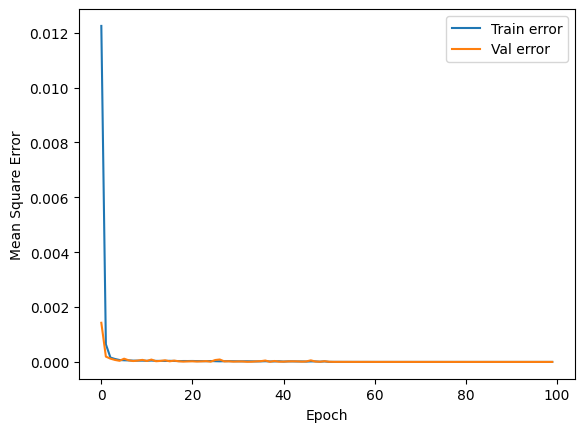

In [81]:
plt.figure()
plt.plot(hist['epoch'], hist['loss'], label='Train error')
plt.plot(hist['epoch'], hist['val_loss'], label='Val error')
plt.xlabel("Epoch")
plt.ylabel("Mean Square Error")
plt.legend()

plt.legend()

In [82]:
targets = pd.DataFrame(data=y_test, columns=INPUT_COLS)
predictions = pd.DataFrame(data=modelGRU.predict(X_test), columns=INPUT_COLS)

targets = denormalize(targets)
predictions = denormalize(predictions)

189/189 [==============================] - 2s 4ms/step


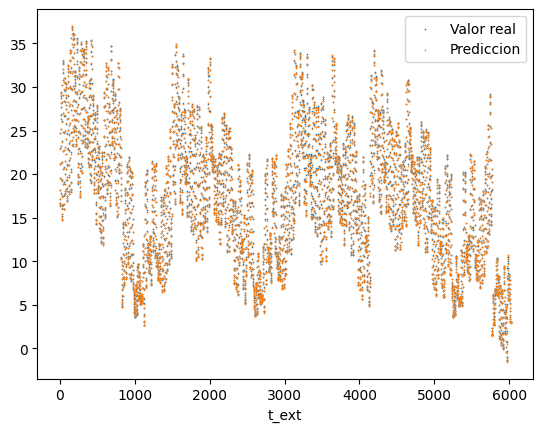

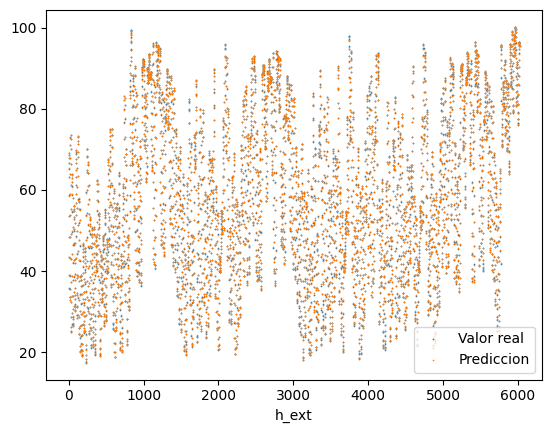

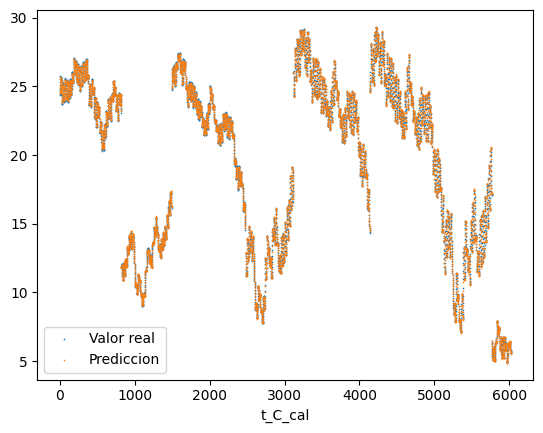

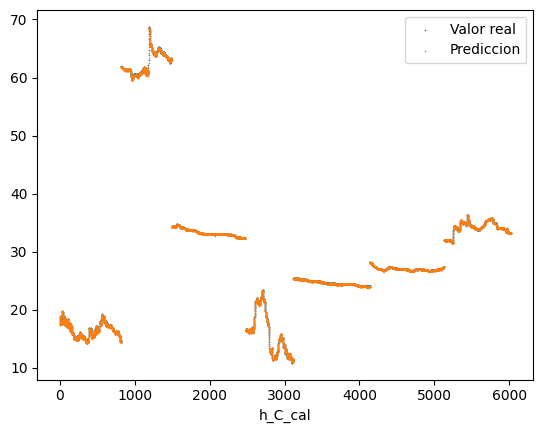

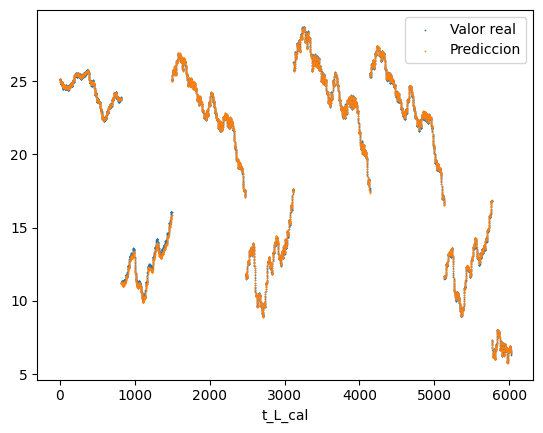

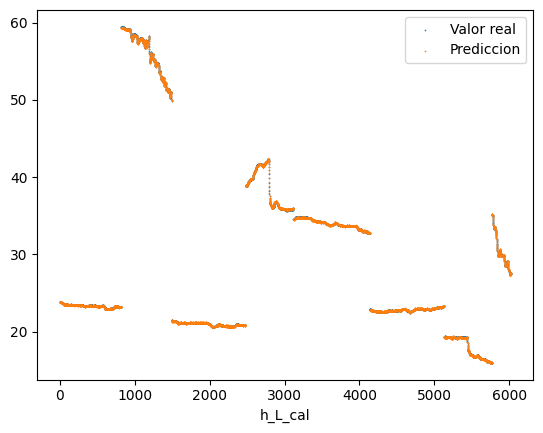

In [83]:
for col in INPUT_COLS:
    plt.figure()
    plt.scatter(range(len(targets[col])), targets[col], linewidths=0.5, s=0.5)
    plt.scatter(range(len(predictions[col])), predictions[col], linewidths=0.5, s=0.5)
    plt.legend(["Valor real", "Prediccion"])
    plt.xlabel(col)
    plt.show()

In [84]:
for col in INPUT_COLS:
    print(col, max(abs(targets[col] - predictions[col])))

t_ext 0.4056594570311489
h_ext 0.34993493840396184
t_C_cal 0.25088594221532645
h_C_cal 0.5500424678217399
t_L_cal 0.33456223253624273
h_L_cal 0.19350386279497656


# LSTM

In [85]:
inputs = layers.Input(shape=X_train.shape[1:])
modelLSTM = layers.LSTM(32, return_sequences=True)(inputs)
modelLSTM = layers.LSTM(16, return_sequences=True)(modelLSTM)
modelLSTM = layers.LSTM(8)(modelLSTM)
outputs = layers.Dense(6)(modelLSTM)

modelLSTM = kr.Model(inputs=inputs, outputs=outputs)
# ch_callback = kr.callbacks.ModelCheckpoint(filepath="./tmp/checkpoint", monitor="val_loss", save_best_only=True, mode="min", verbose=)
modelLSTM.compile(loss="mse", optimizer=get_optimizer())
modelLSTM.summary()

Model: "model_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_9 (InputLayer)        [(None, 6, 6)]            0         
                                                                 
 lstm_6 (LSTM)               (None, 6, 32)             4992      
                                                                 
 lstm_7 (LSTM)               (None, 6, 16)             3136      
                                                                 
 lstm_8 (LSTM)               (None, 8)                 800       
                                                                 
 dense_14 (Dense)            (None, 6)                 54        
                                                                 
Total params: 8,982
Trainable params: 8,982
Non-trainable params: 0
_________________________________________________________________


In [86]:
# Entrenamiento de la RNA
history = modelLSTM.fit(x=X_train, y=y_train, epochs=epochs, batch_size=batch_size, verbose=1, validation_data=(X_val, y_val), callbacks=[sc_callback], workers=10)

Epoch 1/100
177/177 [==============================] - 10s 25ms/step - loss: 0.0161 - val_loss: 0.0043 - lr: 0.0100
Epoch 2/100
177/177 [==============================] - 3s 18ms/step - loss: 9.7884e-04 - val_loss: 6.5828e-04 - lr: 0.0100
Epoch 3/100
177/177 [==============================] - 3s 20ms/step - loss: 2.6534e-04 - val_loss: 3.5234e-04 - lr: 0.0100
Epoch 4/100
177/177 [==============================] - 3s 18ms/step - loss: 2.1685e-04 - val_loss: 2.4307e-04 - lr: 0.0100
Epoch 5/100
177/177 [==============================] - 4s 20ms/step - loss: 1.5398e-04 - val_loss: 2.2764e-04 - lr: 0.0100
Epoch 6/100
177/177 [==============================] - 4s 20ms/step - loss: 1.0595e-04 - val_loss: 1.4679e-04 - lr: 0.0100
Epoch 7/100
177/177 [==============================] - 3s 20ms/step - loss: 8.8970e-05 - val_loss: 8.3949e-05 - lr: 0.0100
Epoch 8/100
177/177 [==============================] - 3s 19ms/step - loss: 8.4552e-05 - val_loss: 7.8116e-05 - lr: 0.0100
Epoch 9/100
177/177 [==

In [87]:
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch

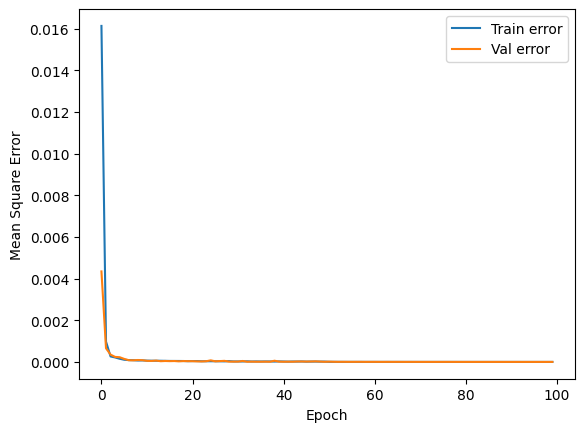

In [88]:
plt.figure()
plt.plot(hist['epoch'], hist['loss'], label='Train error')
plt.plot(hist['epoch'], hist['val_loss'], label='Val error')
plt.xlabel("Epoch")
plt.ylabel("Mean Square Error")
plt.legend()

plt.legend()

In [89]:
targets = pd.DataFrame(data=y_test, columns=INPUT_COLS)
predictions = pd.DataFrame(data=modelLSTM.predict(X_test), columns=INPUT_COLS)

targets = denormalize(targets)
predictions = denormalize(predictions)

189/189 [==============================] - 2s 3ms/step


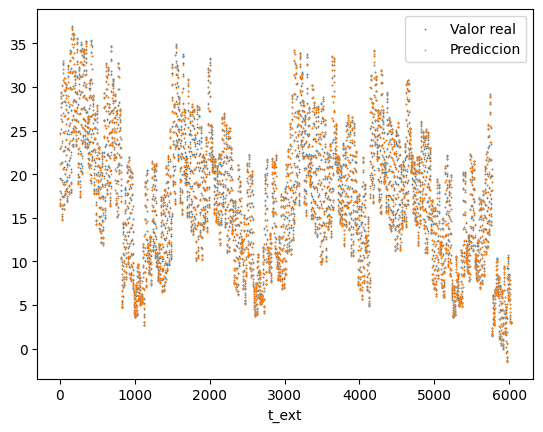

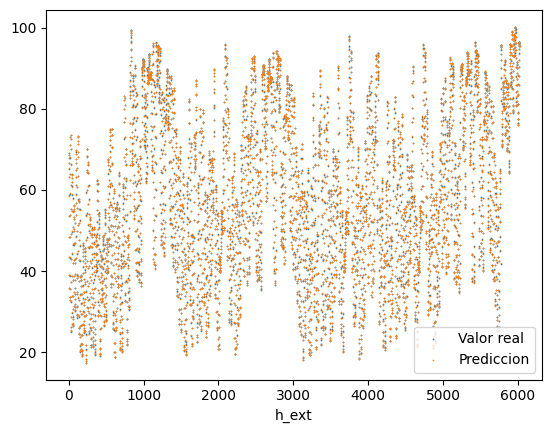

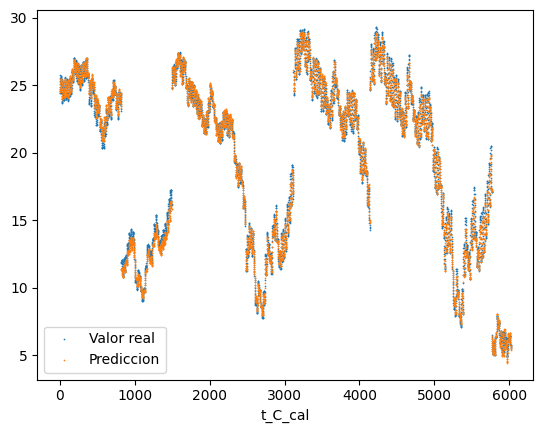

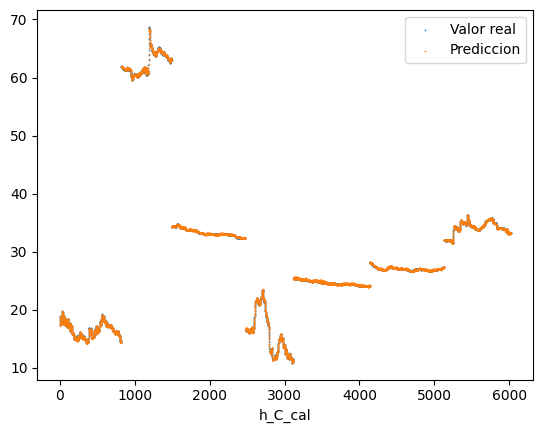

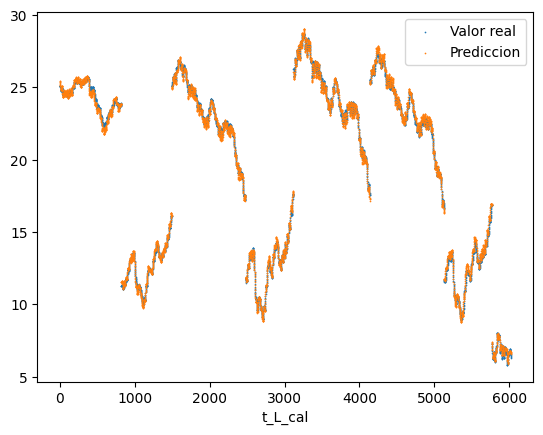

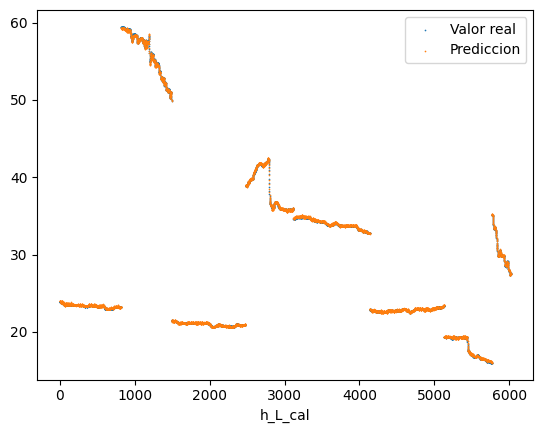

In [90]:
for col in INPUT_COLS:
    plt.figure()
    plt.scatter(range(len(targets[col])), targets[col], linewidths=0.5, s=0.5)
    plt.scatter(range(len(predictions[col])), predictions[col], linewidths=0.5, s=0.5)
    plt.legend(["Valor real", "Prediccion"])
    plt.xlabel(col)
    plt.show()

In [91]:
for col in INPUT_COLS:
    print(col, max(abs(targets[col] - predictions[col])))

t_ext 0.39184722214842793
h_ext 0.4437214840439765
t_C_cal 1.2019695969496809
h_C_cal 0.7138608271967399
t_L_cal 0.9065446675624287
h_L_cal 0.49473047758581856


# MLP

In [92]:
# Modificamos los tensores de entrada transformandoles en vectores de entrada, para que pueden ser empleados por la MLP
X_train_mlp = X_train.reshape((X_train.shape[0], X_train.shape[1] * X_train.shape[2]))
X_val_mlp = X_val.reshape((X_val.shape[0], X_val.shape[1] * X_val.shape[2]))

inputs = layers.Input(shape=X_train_mlp.shape[1:])
modelMLP = layers.Dense(32)(inputs)
modelMLP = layers.Dense(16)(modelMLP)
modelMLP = layers.Dense(8)(modelMLP)
outputs = layers.Dense(6)(modelMLP)

modelMLP = kr.Model(inputs=inputs, outputs=outputs)
modelMLP.compile(loss="mse", optimizer=get_optimizer())
modelMLP.summary()

Model: "model_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_10 (InputLayer)       [(None, 36)]              0         
                                                                 
 dense_15 (Dense)            (None, 32)                1184      
                                                                 
 dense_16 (Dense)            (None, 16)                528       
                                                                 
 dense_17 (Dense)            (None, 8)                 136       
                                                                 
 dense_18 (Dense)            (None, 6)                 54        
                                                                 
Total params: 1,902
Trainable params: 1,902
Non-trainable params: 0
_________________________________________________________________


In [93]:
history = modelMLP.fit(x=X_train_mlp, y=y_train, epochs=epochs, batch_size=batch_size, verbose=1, validation_data=(X_val_mlp, y_val), callbacks=[sc_callback], workers=10)

Epoch 1/100
177/177 [==============================] - 1s 3ms/step - loss: 0.0642 - val_loss: 0.0024 - lr: 0.0100
Epoch 2/100
177/177 [==============================] - 0s 2ms/step - loss: 0.0011 - val_loss: 6.8419e-04 - lr: 0.0100
Epoch 3/100
177/177 [==============================] - 0s 2ms/step - loss: 3.6450e-04 - val_loss: 2.8160e-04 - lr: 0.0100
Epoch 4/100
177/177 [==============================] - 0s 2ms/step - loss: 1.7081e-04 - val_loss: 1.7486e-04 - lr: 0.0100
Epoch 5/100
177/177 [==============================] - 0s 2ms/step - loss: 1.1585e-04 - val_loss: 1.2803e-04 - lr: 0.0100
Epoch 6/100
177/177 [==============================] - 0s 2ms/step - loss: 9.4913e-05 - val_loss: 1.2778e-04 - lr: 0.0100
Epoch 7/100
177/177 [==============================] - 0s 2ms/step - loss: 8.4409e-05 - val_loss: 1.0121e-04 - lr: 0.0100
Epoch 8/100
177/177 [==============================] - 0s 2ms/step - loss: 7.3155e-05 - val_loss: 1.0229e-04 - lr: 0.0100
Epoch 9/100
177/177 [===============

In [94]:
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch

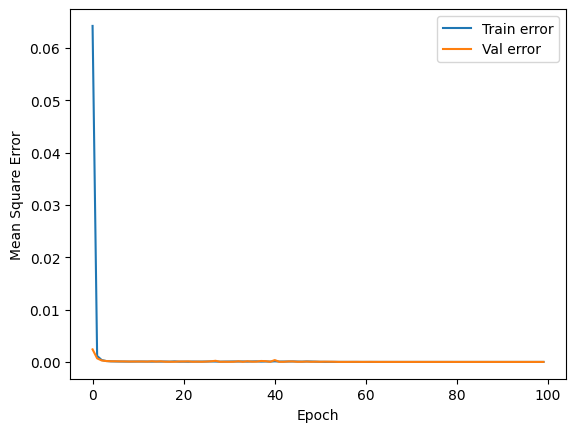

In [95]:
plt.figure()
plt.plot(hist['epoch'], hist['loss'], label='Train error')
plt.plot(hist['epoch'], hist['val_loss'], label='Val error')
plt.xlabel("Epoch")
plt.ylabel("Mean Square Error")
plt.legend()

plt.legend()

In [96]:
X_test_mlp = X_test.reshape((X_test.shape[0], X_test.shape[1] * X_test.shape[2]))

targets = pd.DataFrame(data=y_test, columns=INPUT_COLS)
predictions = pd.DataFrame(data=modelMLP.predict(X_test_mlp), columns=INPUT_COLS)

targets = denormalize(targets)
predictions = denormalize(predictions)

189/189 [==============================] - 0s 1ms/step


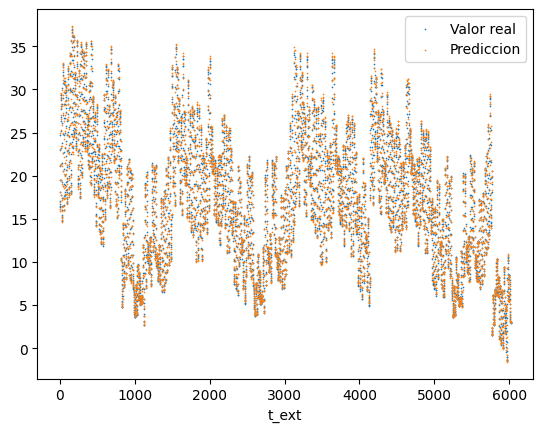

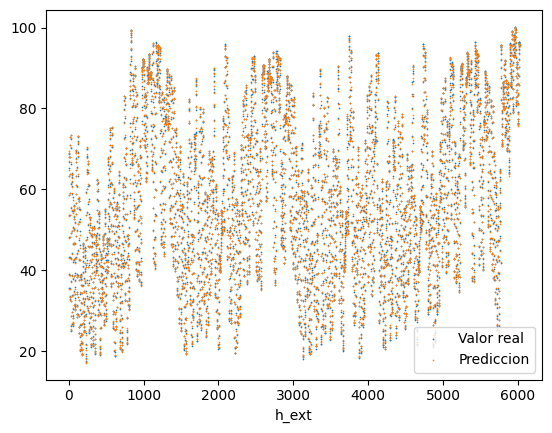

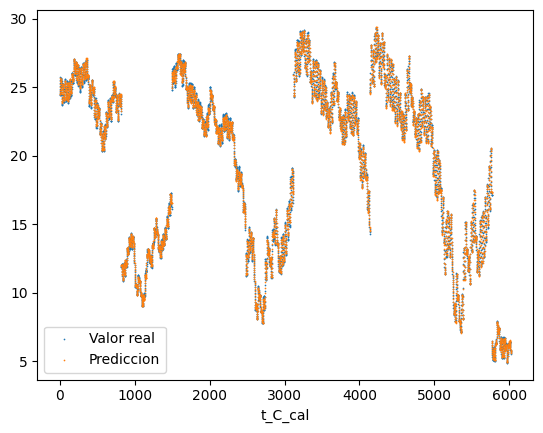

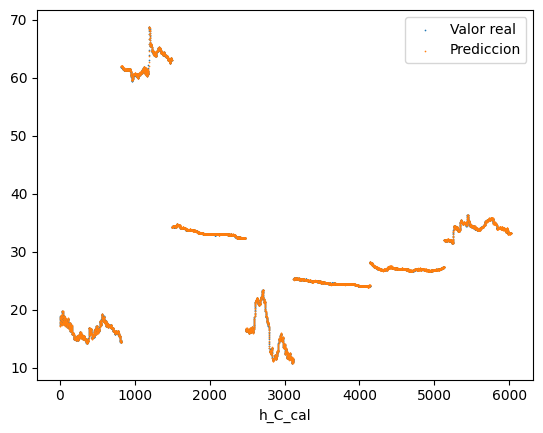

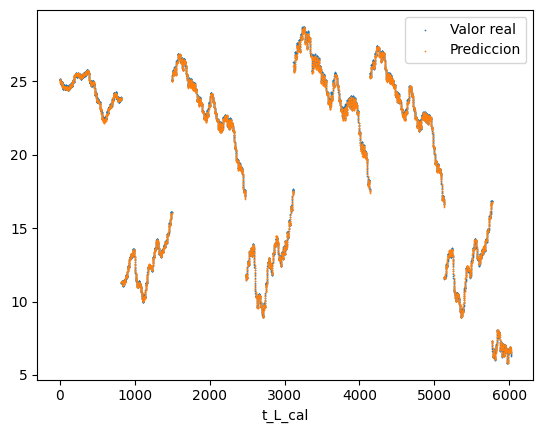

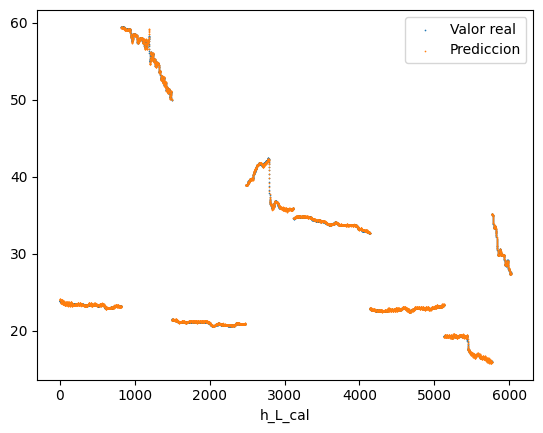

In [97]:
for col in INPUT_COLS:
    plt.figure()
    plt.scatter(range(len(targets[col])), targets[col], linewidths=0.5, s=0.5)
    plt.scatter(range(len(predictions[col])), predictions[col], linewidths=0.5, s=0.5)
    plt.legend(["Valor real", "Prediccion"])
    plt.xlabel(col)
    plt.show()

In [98]:
for col in INPUT_COLS:
    print(col, max(abs(targets[col] - predictions[col])))

t_ext 1.2115941000855628
h_ext 1.1469288103387356
t_C_cal 0.7814699059965875
h_C_cal 1.153607683886193
t_L_cal 0.47731507677175955
h_L_cal 1.3024284891818496


In [99]:
# model.save("./ann_model", overwrite=True)